# Survival Analysis

This is the start of a tutorial on what survival analysis is and how we can use it to help work with HI data which includes both detections and non-detections (aka upper limits). 

Heavily based on: David Stark's survival analysis code (https://github.com/dvstark/survival/tree/main, which was used in Stark et al. 2021. 

This is a work in progress - I had a lot of trouble getting the R packages to play nicely with my installation of python, so this isn't complete yet. 


## What is Survival Analysis? 

Survival analysis describes statistical techniques which are designed to deal with incomplete data. It was initially developed for statistics of time to patient death in medical settings (e.g. to estimate likely life expectancy following a disease). This technique allows an estimate in instances where some fraction of patients survived (yes it's a slightly gruesome name once you know that). 

Most online tutorials use time series data - statistics of when events happen, including times to events which haven't yet happened.

e.g. https://datatab.net/tutorial/survival-analysis 

However this technique can be applied to any data set which is a mixture of measurements and upper limits on that measurement - in our case the data we have is HI detections and upper limits (from non-detections). 

The [Survival Analysis Wikipedia](https://en.wikipedia.org/wiki/Survival_analysis) article has more details on the history of the technique, and names used in applications in other fields, such as engineering (reliability analysis) or economics (duration analysis). 


### Basic Example

Let's start with a basic example using some made up data. 

**IMPORTANT** You will need to put the code `survival.py` from  David Stark's survival analysis code respository (https://github.com/dvstark/survival/tree/main) into the directory you are running this code from. 

In [1]:
#Import statements

#import os
#os.chdir('/Users/dstark/python_packages/my_packages/survival/')
#print(os.getcwd())
#You need the above three lines if you put the survival.py anywhere but in the directory you are running this Notebook from
#And you will need to edit it to tell this notebook where it can find survival.py on your computer 
#(or the server you are running this notebook on)

#You may also need rpy2 module to be imported. 
#Open a terminal and type what is inside the three square brackets below if that is the case: 
#[[[conda install conda-forge::rpy2]]]
#OK so this might be fun - it needs python 3.8, which might not be what you are running.... 
#And then it migth also tell you other modules are missing. Sigh.
#Honestly it took me almost an hour to get these three lines of code to run on my laptop.. 
#I had to make a new conda environment for python 3.8, then install a bunch of modules.
#For now I gave up on Sciserver. 
from survival import setup, ats_fit, kaplan_meier

import numpy as np
import matplotlib.pyplot as plt

In [8]:
#Run Dave Stark's setup script (sets up R and stuff)
setup()

R[write to console]: Warning:
R[write to console]:  dependency ‘Matrix’ is not available

R[write to console]: trying URL 'https://lib.stat.cmu.edu/R/CRAN/src/contrib/survival_3.8-3.tar.gz'

R[write to console]: Content type 'application/x-gzip'
R[write to console]:  length 9537074 bytes (9.1 MB)

R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to 

In [15]:
from rpy2.robjects.packages import importr
utils = importr('utils')
utils.install_packages("survival")

NameError: name 'TRUE' is not defined

NameError: name 'library' is not defined

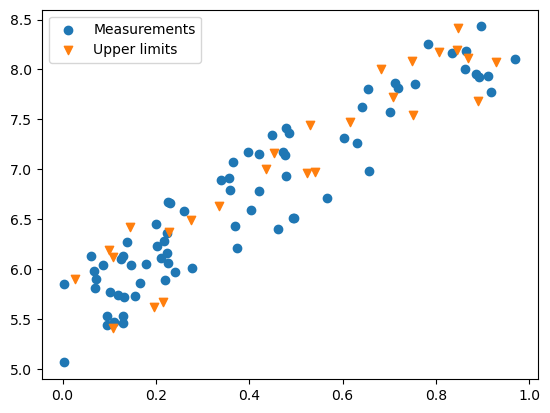

In [5]:
#let's make some fake data
x = np.random.uniform(size=100) #Make a unfiform random distrobution of 100 x values from 0-1
y = 5 + (3 * x) + np.random.uniform(size=100) #Just a line with error of size 0-1

# set ~30% to be upper limits in y
lims = np.zeros(len(x)).astype(bool) #Sets up a logic array of all "FALSE" entries
lims[np.random.choice(np.arange(len(lims)), size=int(0.3*len(lims)))] = True #Randomly sets 30% of them to be TRUE

plt.scatter(x[~lims],y[~lims],label='Measurements') #Scatter plot of the actually measurement (NOT lims is ~lims)
plt.scatter(x[lims], y[lims], marker='v',label='Upper limits') #Scatter plot of the upper limits (lims=TRUE entries)
plt.legend()

### Akritas-Theil-Sen estimator

The Akritas-Theil-Sen (ATS) estimator (Akritas et al. 1995) is a method which can be used to fit a line to data in the presence of upper limits. 

More should be written here about how this works, but first think about the problem - usually line fits is done by minimising some kind of sum of the distance from the points to the best fit line. With upper limits you don't know the actual distance, only the minimum/maximum it could be (for upper limits below/above the line of best fit). So this technique accounts for that by minimising a median value of residuals using other techniques for calculating medians in the presence of upper limits (I think that's what I understand anyway). 

In [13]:
#This command (a function from survival.py) runs cenken from R (Akritas-Theil-Sen estimator) to determine correlation 
# strength and line fit parameters in the presence of upper limits

out = ats_fit(x,y,lims,fmt='(I4, 2F10.3)')
out

R[write to console]: Error in library(survival) : there is no package called ‘survival’



RRuntimeError: Error in library(survival) : there is no package called ‘survival’
